# **Pirate Pain Challenge - Recurren Neural Network**
![image.png](images/rnn.png)

## 🌐 **Google Drive Connection or local mount**

In [74]:
import os

isColab = False

try:
    from google.colab import drive

    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-1"
    print("Running in Google Colab. Google Drive mounted.")
    %cd $current_dir
    isColab = True
except ImportError:
    print("Running in a local environment. Skipping Google Drive mount.")
    current_dir = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1"
    if not os.path.isdir(current_dir):
        current_dir = os.getcwd()
    print(f"Current directory set to: {current_dir}")
if not isColab:
    os.chdir(current_dir)
print(f"Changed directory to: {current_dir}")

Running in a local environment. Skipping Google Drive mount.
Current directory set to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1
Changed directory to: G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-1


## ⚙️ **Libraries Import**

In [75]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch

torch.manual_seed(SEED)
# from torchsummary import summary

logs_dir = "tensorboard"
if isColab:
    !pkill -f tensorboard
else:
    # Arresta eventuali processi tensorboard in locale (Windows)
    import os

    if os.name == 'nt':
        try:
            import psutil

            for proc in psutil.process_iter(['name', 'cmdline']):
                name = (proc.info.get('name') or '').lower()
                cmd = ' '.join(proc.info.get('cmdline') or []).lower()
                if 'tensorboard' in name or 'tensorboard' in cmd:
                    try:
                        proc.kill()
                    except Exception:
                        pass
        except ImportError:
            import subprocess

            subprocess.run(['taskkill', '/F', '/IM', 'tensorboard.exe'],
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

%load_ext tensorboard
if isColab:
    !mkdir -p models
else:
    os.makedirs("models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu130
Device: cuda


## ⏳ **Data Downloading**

In [76]:
import os
import zipfile

# --- 1. Impostazioni ---
competition_name = 'an2dl2526c1'
dataset_path = 'dataset'
train_file = 'pirate_pain_train.csv'
test_file = 'pirate_pain_test.csv'
labels_file = 'pirate_pain_train_labels.csv'
sample_submission_file = 'sample_submission.csv'

# Controlla se il dataset è già stato scaricato ed estratto
if not os.path.exists(os.path.join(dataset_path, train_file)):
    # --- 2. Autenticazione e Download ---
    from kaggle.api.kaggle_api_extended import KaggleApi

    # Inizializza l'API di Kaggle
    # L'autenticazione avviene automaticamente se 'kaggle.json' è in C:\\Users\\Bert0ns\\.kaggle\\
    api = KaggleApi()
    api.authenticate()

    print(f"Download del dataset dalla competizione '{competition_name}'...")

    # Crea la directory di destinazione se non esiste
    os.makedirs(dataset_path, exist_ok=True)

    # Scarica i file della competizione nella cartella 'dataset'
    api.competition_download_files(competition_name, path=dataset_path)

    # Estrai i file dall'archivio zip
    zip_path = os.path.join(dataset_path, f'{competition_name}.zip')
    if os.path.exists(zip_path):
        print(f"Estrazione dei file da '{zip_path}'...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_path)
        # Rimuovi il file zip dopo l'estrazione
        os.remove(zip_path)
        print("Estrazione completata e file zip rimosso.")
    else:
        print("ATTENZIONE: File zip non trovato. Il download potrebbe non essere riuscito.")
else:
    print("Il dataset è già presente nella cartella 'dataset'. Download saltato.")


Il dataset è già presente nella cartella 'dataset'. Download saltato.


## 🔎 **Exploration and Data Analysis**

In [77]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv(os.path.join(dataset_path, train_file))
kaggle_test_df = pd.read_csv(os.path.join(dataset_path, test_file))
labels_df = pd.read_csv(os.path.join(dataset_path, labels_file))
sample_submission_df = pd.read_csv(os.path.join(dataset_path, sample_submission_file))

#### **Convert data to a memory efficient form**

In [78]:
na_value = -1
text_map = {
    'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
    'unknown': na_value, 'nan': na_value, 'none': na_value, 'n/a': na_value,
    'one+peg_leg': 1, 'one+hook_hand': 1, 'one+eye_patch': 1,
    'no_pain': 0, 'low_pain': 1, 'high_pain': 2
}

# Pulisce, normalizza, mappa; fallback a numerico e a cifre estratte
columns_to_convert = ['n_legs', 'n_hands', 'n_eyes']
for col in columns_to_convert:
    train_df[col] = train_df[col].str.strip().str.lower().map(text_map).astype('int8')
    kaggle_test_df[col] = kaggle_test_df[col].str.strip().str.lower().map(text_map).astype('int8')

# train_df.head(105760)

In [79]:
# Convert data types from float64 to float32 to save memory
train_df[train_df.select_dtypes(include=['float64']).columns] = train_df.select_dtypes(include=['float64']).astype(
    'float32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['float64']).columns] = kaggle_test_df.select_dtypes(
    include=['float64']).astype(
    'float32')

# Convert int64 to int32
train_df[train_df.select_dtypes(include=['int64']).columns] = train_df.select_dtypes(include=['int64']).astype('int32')
kaggle_test_df[kaggle_test_df.select_dtypes(include=['int64']).columns] = kaggle_test_df.select_dtypes(
    include=['int64']).astype('int32')
labels_df[labels_df.select_dtypes(include=['int64']).columns] = labels_df.select_dtypes(include=['int64']).astype(
    'int32')

# Convert pain surveys to int8
train_df['pain_survey_1'] = train_df['pain_survey_1'].astype('int8')
train_df['pain_survey_2'] = train_df['pain_survey_2'].astype('int8')
train_df['pain_survey_3'] = train_df['pain_survey_3'].astype('int8')
train_df['pain_survey_4'] = train_df['pain_survey_4'].astype('int8')

kaggle_test_df['pain_survey_1'] = kaggle_test_df['pain_survey_1'].astype('int8')
kaggle_test_df['pain_survey_2'] = kaggle_test_df['pain_survey_2'].astype('int8')
kaggle_test_df['pain_survey_3'] = kaggle_test_df['pain_survey_3'].astype('int8')
kaggle_test_df['pain_survey_4'] = kaggle_test_df['pain_survey_4'].astype('int8')

# Convert labels sample_index to int8
labels_df['label'] = labels_df['label'].str.strip().str.lower().map(text_map).astype('int8')

In [80]:
joint_columns = [f'joint_{i:02d}' for i in range(31)]

## 🔄 **Data Preprocessing**

#### Split train_df in train, validation, test sub-datasets

In [81]:
VALIDATION_SET_PERCENTAGE = 0.15
TEST_SET_PERCENTAGE = 0.15

unique_samples = train_df['sample_index'].unique()
random.seed(SEED)
np.random.shuffle(unique_samples)

N_VAL_SAMPLES = int(VALIDATION_SET_PERCENTAGE * len(unique_samples))
N_TEST_SAMPLES = int(TEST_SET_PERCENTAGE * len(unique_samples))
N_TRAIN_SAMPLES = len(unique_samples) - N_VAL_SAMPLES - N_TEST_SAMPLES

# split indexes
train_samples = unique_samples[:N_TRAIN_SAMPLES]
val_samples = unique_samples[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES + N_VAL_SAMPLES]
test_samples = unique_samples[N_TRAIN_SAMPLES + N_VAL_SAMPLES:]

# split
df_train = train_df[train_df['sample_index'].isin(train_samples)]
df_test = train_df[train_df['sample_index'].isin(test_samples)]
df_val = train_df[train_df['sample_index'].isin(val_samples)]

print(f"Train samples: {df_train.shape}")
print(f"Validation samples: {df_val.shape}")
print(f"Test samples: {df_test.shape}")

Train samples: (74080, 40)
Validation samples: (15840, 40)
Test samples: (15840, 40)


In [82]:
# @title Normalize data: MinMaxScaler
# Normalize all features to [0, 1] range using MinMaxScaler, features excluded: [sample_index, time]
from sklearn.preprocessing import MinMaxScaler

continuous_cols = joint_columns
categorical_cols = ['n_legs', 'n_hands', 'n_eyes', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

scaler = MinMaxScaler()

# Normalize only continuous features
df_train[continuous_cols] = scaler.fit_transform(df_train[continuous_cols])
df_val[continuous_cols] = scaler.transform(df_val[continuous_cols])
df_test[continuous_cols] = scaler.transform(df_test[continuous_cols])

# Normalize also the kaggle test set
kaggle_test_df[continuous_cols] = scaler.transform(kaggle_test_df[continuous_cols])

#### **Remove useless features**

In [83]:
# @title Remove feature from joint_13 to joint_25 + joint_30
columns_to_remove = [f'joint_{i:02d}' for i in range(13, 26)] + ['joint_30']

df_train_reduced = df_train.drop(columns=columns_to_remove, inplace=False)
df_test_reduced = df_test.drop(columns=columns_to_remove, inplace=False)
df_val_reduced = df_val.drop(columns=columns_to_remove, inplace=False)

kaggle_test_df_reduced = kaggle_test_df.drop(columns=columns_to_remove, inplace=False)

In [84]:
# Fatto da Gemini

def plot_pca_of_person_joint_means(train_full_df, labels_df, joint_cols=None, n_components=2, palette=None,
                                   figsize=(10, 8), seed=SEED):
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    if joint_cols is None:
        joint_cols = [f'joint_{i:02d}' for i in range(31)]

    # Calcola la media dei giunti per persona
    person_avg_df_local = train_full_df.groupby('sample_index')[joint_cols].mean()

    # Unisci con le etichette per la colorazione
    person_avg_df_local = pd.merge(person_avg_df_local, labels_df, on='sample_index')

    # Standardizza i dati
    X = person_avg_df_local[joint_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    # Applica PCA
    pca_local = PCA(n_components=n_components, random_state=seed)
    principal_components = pca_local.fit_transform(X_scaled)

    # Prepara DataFrame dei componenti principali
    cols = [f'PC {i + 1}' for i in range(n_components)]
    pca_df_local = pd.DataFrame(data=principal_components, columns=cols)
    pca_df_local['label'] = person_avg_df_local['label'].values

    # Visualizza i risultati (prima due componenti)
    plt.figure(figsize=figsize)
    if palette is None:
        palette = {0: 'green', 1: 'orange', 2: 'red'}

    sns.scatterplot(
        x='PC 1',
        y='PC 2',
        hue='label',
        palette=palette,
        data=pca_df_local,
        alpha=0.7,
        s=100
    )
    plt.title('Visualizzazione PCA dei Dati Medi dei Giunti per Persona')
    plt.xlabel('Componente Principale 1')
    plt.ylabel('Componente Principale 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Livello di Dolore')
    plt.show()

    return pca_local, pca_df_local, person_avg_df_local

In [85]:
df_train_reduced.info()
df_test_reduced.info()
df_val_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74080 entries, 0 to 105759
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sample_index   74080 non-null  int32  
 1   time           74080 non-null  int32  
 2   pain_survey_1  74080 non-null  int8   
 3   pain_survey_2  74080 non-null  int8   
 4   pain_survey_3  74080 non-null  int8   
 5   pain_survey_4  74080 non-null  int8   
 6   n_legs         74080 non-null  int8   
 7   n_hands        74080 non-null  int8   
 8   n_eyes         74080 non-null  int8   
 9   joint_00       74080 non-null  float32
 10  joint_01       74080 non-null  float32
 11  joint_02       74080 non-null  float32
 12  joint_03       74080 non-null  float32
 13  joint_04       74080 non-null  float32
 14  joint_05       74080 non-null  float32
 15  joint_06       74080 non-null  float32
 16  joint_07       74080 non-null  float32
 17  joint_08       74080 non-null  float32
 18  joint_09  

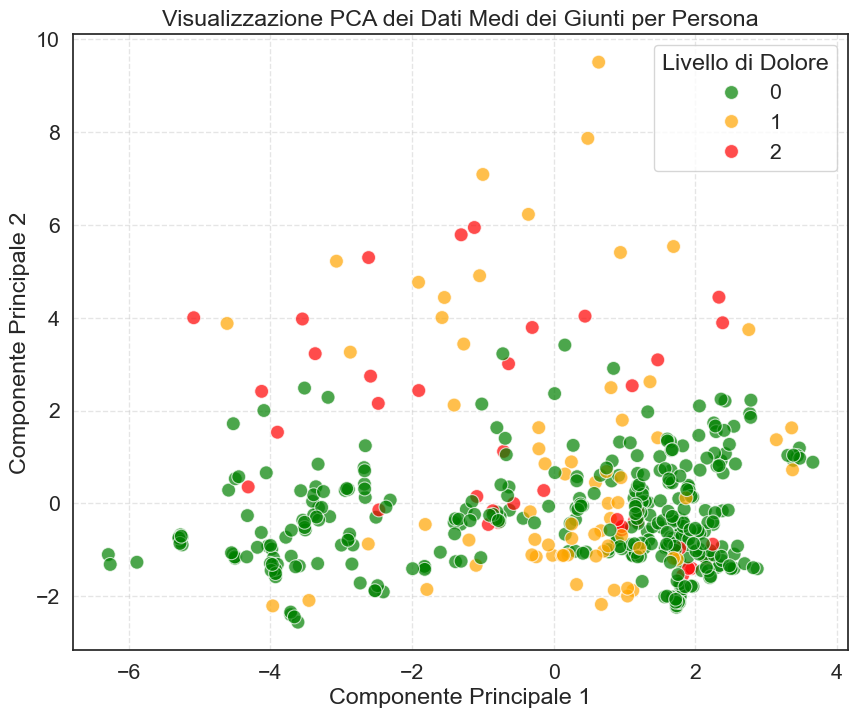

(PCA(n_components=2, random_state=42),
          PC 1      PC 2  label
 0    1.595028 -0.930086      0
 1   -4.612529  3.877418      1
 2    1.656178  0.485017      0
 3    2.547651 -1.091247      0
 4    1.134237  0.113672      0
 ..        ...       ...    ...
 458 -3.705126 -0.575920      0
 459 -3.662622 -2.443802      0
 460  0.795394 -0.572360      0
 461  0.386852 -0.052509      0
 462 -0.744494  0.402512      0
 
 [463 rows x 3 columns],
      sample_index  joint_00  joint_01  joint_02  joint_03  joint_04  joint_05  \
 0               0  0.740976  0.768897  0.750716  0.785050  0.779587  0.760767   
 1               2  0.093164  0.028599  0.102969  0.277445  0.766022  0.552006   
 2               3  0.762451  0.776101  0.737433  0.786281  0.839849  0.784967   
 3               5  0.787195  0.811638  0.751492  0.753720  0.841466  0.786983   
 4               6  0.727708  0.790342  0.719762  0.798181  0.719040  0.699280   
 ..            ...       ...       ...       ...       ...

In [86]:
joint_columns = [col for col in joint_columns if col not in columns_to_remove]
plot_pca_of_person_joint_means(pd.merge(df_train_reduced, labels_df, on='sample_index'), labels_df,
                               joint_cols=joint_columns)

#### **Build sequeces with sliding window**

In [87]:
# Define the window size
WINDOW_SIZE = 200

# Define the stride for overlapping windows
STRIDE = 50

In [88]:
# Define a function to build sequences from the dataset
def build_sequences(df, label_df, continuous_cols, categorical_cols, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset_continuous = []
    dataset_categorical = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        temp_continuous = df[df['sample_index'] == id][continuous_cols].values
        temp_categorical = df[df['sample_index'] == id][categorical_cols].values

        # Retrieve the activity label for the current ID
        label = label_df[label_df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp_continuous) % window

        # Create zero padding and concatenate with the data
        padding_cont = np.zeros((padding_len, temp_continuous.shape[1]), dtype='float32')
        padding_cat = np.zeros((padding_len, temp_categorical.shape[1]),
                               dtype='int8')  # Padding con 0 per le categoriche
        temp_continuous = np.concatenate((temp_continuous, padding_cont))
        temp_categorical = np.concatenate((temp_categorical, padding_cat))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_continuous):
            dataset_continuous.append(temp_continuous[idx:idx + window])
            dataset_categorical.append(temp_categorical[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset_continuous = np.array(dataset_continuous)
    dataset_categorical = np.array(dataset_categorical)
    labels = np.array(labels)

    return dataset_continuous, dataset_categorical, labels

In [89]:
# Rimuoviamo le colonne eliminate anche dalle nostre liste di colonne
continuous_cols_reduced = [col for col in continuous_cols if col not in columns_to_remove]
categorical_cols_reduced = [col for col in categorical_cols if col not in columns_to_remove]

# Creiamo le sequenze
X_train_cont, X_train_cat, y_train = build_sequences(df_train_reduced, labels_df, continuous_cols_reduced,
                                                     categorical_cols_reduced, window=WINDOW_SIZE, stride=STRIDE)
X_val_cont, X_val_cat, y_val = build_sequences(df_val_reduced, labels_df, continuous_cols_reduced,
                                               categorical_cols_reduced, window=WINDOW_SIZE, stride=STRIDE)
X_test_cont, X_test_cat, y_test = build_sequences(df_test_reduced, labels_df, continuous_cols_reduced,
                                                  categorical_cols_reduced, window=WINDOW_SIZE, stride=STRIDE)

print(f"Train set: X_cont={X_train_cont.shape}, X_cat={X_train_cat.shape}, y={y_train.shape}")
print(f"Validation set: X_cont={X_val_cont.shape}, X_cat={X_val_cat.shape}, y={y_val.shape}")
print(f"Test set: X_cont={X_test_cont.shape}, X_cat={X_test_cat.shape}, y={y_test.shape}")

Train set: X_cont=(463, 200, 17), X_cat=(463, 200, 7), y=(463,)
Validation set: X_cont=(99, 200, 17), X_cat=(99, 200, 7), y=(99,)
Test set: X_cont=(99, 200, 17), X_cat=(99, 200, 7), y=(99,)


#### **Convert data sets in TensorDatasets**

In [90]:
from torch.utils.data import TensorDataset

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train_cont), torch.from_numpy(X_train_cat).long(),
                         torch.from_numpy(y_train).long())
val_ds = TensorDataset(torch.from_numpy(X_val_cont), torch.from_numpy(X_val_cat).long(), torch.from_numpy(y_val).long())
test_ds = TensorDataset(torch.from_numpy(X_test_cont), torch.from_numpy(X_test_cat).long(),
                        torch.from_numpy(y_test).long())

In [91]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 512

In [92]:
from torch.utils.data import DataLoader


def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [93]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [94]:
# Get one batch from the training data loader (now yields continuous, categorical, labels)
for xb_cont, xb_cat, yb in train_loader:
    print("Continuous features batch shape:", xb_cont.shape)
    print("Categorical features batch shape:", xb_cat.shape)
    print("Labels batch shape:", yb.shape)
    break  # Stop after getting one batch

Continuous features batch shape: torch.Size([256, 200, 17])
Categorical features batch shape: torch.Size([256, 200, 7])
Labels batch shape: torch.Size([256])


In [95]:
# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

## 🛠️ **Model Building**

In [96]:
from torch import nn


def recurrent_summary(model, input_specs):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers. It supports models with multiple inputs.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_specs (list of tuples): A list where each tuple contains the shape
                                     and dtype of an input tensor.
                                     Example: [((seq_len, features_cont), torch.float32),
                                               ((seq_len, features_cat), torch.long)]
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""

        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"

        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_inputs = []
    for shape, dtype in input_specs:
        if dtype in [torch.long, torch.int, torch.int8, torch.int16, torch.int32, torch.int64]:
            dummy_inputs.append(torch.zeros(1, *shape, dtype=dtype).to(device))
        else:
            dummy_inputs.append(torch.randn(1, *shape, dtype=dtype).to(device))

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM, nn.ModuleList)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(*dummy_inputs)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [97]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier with Embedding layer for categorical features.
    """

    def __init__(
            self,
            continuous_input_size,
            categorical_cardinalities,
            embedding_dims,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
    ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # 1. Embedding Layers per le feature categoriche
        self.embedding_layers = nn.ModuleList([
            nn.Embedding(num_embeddings, emb_dim)
            for num_embeddings, emb_dim in zip(categorical_cardinalities, embedding_dims)
        ])
        total_embedding_dim = sum(embedding_dims)

        # 2. Calcola la dimensione dell'input per la RNN
        rnn_input_size = continuous_input_size + total_embedding_dim

        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")
        rnn_module = rnn_map[rnn_type]

        dropout_val = dropout_rate if num_layers > 1 else 0

        # 3. Crea il layer ricorrente
        self.rnn = rnn_module(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        classifier_input_size = hidden_size * 2 if self.bidirectional else hidden_size
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x_continuous, x_categorical):
        """
        x_continuous shape: (batch_size, seq_length, num_continuous_features)
        x_categorical shape: (batch_size, seq_length, num_categorical_features)
        """
        # 1. Applica gli embedding
        embedded_features = []
        for i, emb_layer in enumerate(self.embedding_layers):
            # Prendi la i-esima feature categorica per tutti i timestep
            cat_feature = x_categorical[:, :, i]
            embedded_features.append(emb_layer(cat_feature))

        # 2. Concatena gli embedding
        # embedded_features è una lista di tensori (batch, seq, emb_dim)
        # li concateniamo lungo l'ultima dimensione
        x_embedded = torch.cat(embedded_features, dim=-1)

        # 3. Concatena le feature continue con quelle embedded
        x_combined = torch.cat([x_continuous, x_embedded], dim=-1)

        # 4. Passa il tensore combinato alla RNN
        rnn_out, hidden = self.rnn(x_combined)

        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]

        logits = self.classifier(hidden_to_classify)
        return logits

## 🧮 **Network and Training Hyperparameters**

In [98]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2  # Hidden layers
HIDDEN_SIZE = 128  # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2  # Dropout probability
L1_LAMBDA = 0  # L1 penalty
L2_LAMBDA = 0  # L2 penalty

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = total_samples / (len(np.unique(y_train)) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Set up loss function and optimizer with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# criterion = nn.CrossEntropyLoss()

## 🧠 **Model Training**

### **Utility Functions**

In [99]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [100]:
from sklearn.metrics import f1_score


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs_cont, inputs_cat, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(
                device.type == 'cuda')):  # consider to add dtype=torch.float16 to improve speed
            logits = model(inputs_cont, inputs_cat)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs_cont.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [101]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs_cont, inputs_cat, targets in val_loader:
            # Sposta i dati sul dispositivo corretto
            inputs_cont, inputs_cat, targets = inputs_cont.to(device), inputs_cat.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs_cont, inputs_cat)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs_cont.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [102]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [103]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                      f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Training Loop**

#### **Instantiating Model**

In [104]:
# Create model and display architecture with parameter count

# Definiamo le cardinalità (numero di valori unici) per ogni feature categorica.
# La cardinalità deve essere il valore massimo della categoria + 1.
# Questo assicura che tutti gli indici siano validi per il layer di embedding.
categorical_cardinalities = [
    int(train_df['n_legs'].max() + 1),
    int(train_df['n_hands'].max() + 1),
    int(train_df['n_eyes'].max() + 1),
    int(train_df['pain_survey_1'].max() + 1),
    int(train_df['pain_survey_2'].max() + 1),
    int(train_df['pain_survey_3'].max() + 1),
    int(train_df['pain_survey_4'].max() + 1)
]

# Definiamo la dimensione dell'embedding per ogni feature.
# Una regola comune è min(50, (cardinalità+1)//2)
embedding_dims = [min(50, (c + 1) // 2) for c in categorical_cardinalities]

# Crea il modello
rnn_model = RecurrentClassifier(
    continuous_input_size=X_train_cont.shape[-1],
    categorical_cardinalities=categorical_cardinalities,
    embedding_dims=embedding_dims,
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='RNN'
).to(device)

recurrent_summary(rnn_model, [
    ((X_train_cont.shape[1], X_train_cont.shape[2]), torch.float32),
    ((X_train_cat.shape[1], X_train_cat.shape[2]), torch.long)
])

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 200, 128], [2, -1, 128]] 53,632         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,019
Trainable params: 54,019
Non-trainable params: 0
-------------------------------------------------------------------------------
RecurrentClassifier(
  (embedding_layers): ModuleList(
    (0-6): 7 x Embedding(3, 2)
  )
  (rnn): RNN(31, 128, num_layers=2, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
experiment_name = "rnn_with_embeddings"

In [105]:
from torch.utils.tensorboard import SummaryWriter

# Set up TensorBoard logging and save model architecture
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

x_cont_dummy = torch.randn(1, X_train_cont.shape[1], X_train_cont.shape[2]).to(device)
x_cat_dummy = torch.zeros(1, X_train_cat.shape[1], X_train_cat.shape[2], dtype=torch.long).to(device)
writer.add_graph(rnn_model, (x_cont_dummy, x_cat_dummy))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=PATIENCE
)

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   9/500 | Train: Loss=1.0967, F1 Score=0.4464 | Val: Loss=1.1014, F1 Score=0.0121
Epoch  10/500 | Train: Loss=1.1019, F1 Score=0.4167 | Val: Loss=1.1044, F1 Score=0.0121


In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# @title Plot Confusion Matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and ground truth labels
val_preds, val_targets = [], []
rnn_model.eval()  # Assicurati che il modello sia in modalità valutazione
with torch.no_grad():  # Disable gradient computation for inference
    # Itera sul validation loader che ora restituisce tre tensori
    for inputs_cont, inputs_cat, targets in val_loader:
        # Sposta gli input sul dispositivo corretto
        inputs_cont = inputs_cont.to(device)
        inputs_cat = inputs_cat.to(device)

        # Forward pass: ottieni i logits del modello con i due input
        logits = rnn_model(inputs_cont, inputs_cat)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(targets.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_prec:.4f}")
print(f"Validation Recall: {val_rec:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Print classification report
class_names = ['no_pain', 'low_pain', 'high_pain']
print("\nClassification Report:")
print(classification_report(val_targets, val_preds, target_names=class_names))

# Compute and plot the confusion matrix
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## **Inference on Kaggle Test Set**

In [ ]:
INFERENCE_RESULTS_CSV_NAME = "kaggle_inference_results_rnn_v2.csv"

In [ ]:
# 1. Creare una funzione per costruire sequenze per il set di test di Kaggle
def build_kaggle_sequences(df, continuous_cols, categorical_cols, window=200, stride=50):
    """
    Costruisce sequenze di feature continue e categoriche per il set di test di Kaggle.
    """
    dataset_continuous = []
    dataset_categorical = []
    sample_indices = []

    # Itera su ogni ID univoco nel DataFrame
    for id in df['sample_index'].unique():
        # Estrai i dati continui e categorici per l'ID corrente
        temp_continuous = df[df['sample_index'] == id][continuous_cols].values
        temp_categorical = df[df['sample_index'] == id][categorical_cols].values

        # Calcola e applica il padding se necessario per avere finestre complete
        padding_len = window - len(temp_continuous) % window if len(temp_continuous) % window != 0 else 0
        if padding_len > 0:
            padding_cont = np.zeros((padding_len, temp_continuous.shape[1]), dtype='float32')
            padding_cat = np.zeros((padding_len, temp_categorical.shape[1]), dtype='int8')
            temp_continuous = np.concatenate((temp_continuous, padding_cont))
            temp_categorical = np.concatenate((temp_categorical, padding_cat))

        # Crea finestre scorrevoli
        idx = 0
        while idx + window <= len(temp_continuous):
            dataset_continuous.append(temp_continuous[idx:idx + window])
            dataset_categorical.append(temp_categorical[idx:idx + window])
            sample_indices.append(id)
            idx += stride

    # Converti le liste in array numpy
    dataset_continuous = np.array(dataset_continuous, dtype='float32')
    dataset_categorical = np.array(dataset_categorical, dtype='int64')
    sample_indices = np.array(sample_indices)

    return dataset_continuous, dataset_categorical, sample_indices

In [ ]:
import pandas as pd
from scipy.stats import mode


# 2. Pre-elabora il set di test di Kaggle e crea le sequenze
X_kaggle_cont, X_kaggle_cat, kaggle_indices = build_kaggle_sequences(kaggle_test_df_reduced, continuous_cols_reduced, categorical_cols_reduced, window=WINDOW_SIZE, stride=STRIDE)

# 3. Crea un DataLoader per il set di test di Kaggle
kaggle_ds = TensorDataset(torch.from_numpy(X_kaggle_cont), torch.from_numpy(X_kaggle_cat).long())
kaggle_loader = make_loader(kaggle_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# 4. Esegui l'inferenza
rnn_model.eval()  # Imposta il modello in modalità valutazione
all_preds = []
with torch.no_grad():
    for inputs_cont, inputs_cat in kaggle_loader:
        inputs_cont, inputs_cat = inputs_cont.to(device), inputs_cat.to(device)
        logits = rnn_model(inputs_cont, inputs_cat)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)

all_preds = np.concatenate(all_preds)

# 5. Aggrega le previsioni per ogni 'sample_index'
results = pd.DataFrame({'sample_index': kaggle_indices, 'prediction': all_preds})
final_predictions = results.groupby('sample_index')['prediction'].apply(lambda x: mode(x, keepdims=True)[0][0]).reset_index()
final_predictions.rename(columns={'prediction': 'label'}, inplace=True)


# 6. Crea il file di sottomissione
# Mappa le etichette numeriche alle stringhe originali
label_map_inv = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
final_predictions['label'] = final_predictions['label'].map(label_map_inv)

# Assicurati che tutte le previsioni siano presenti
submission_df = pd.merge(sample_submission_df[['sample_index']], final_predictions, on='sample_index', how='left')

# Salva il file CSV
submission_df.to_csv(INFERENCE_RESULTS_CSV_NAME, index=False)

print(f"File di sottomissione '{INFERENCE_RESULTS_CSV_NAME}' creato con successo.")
submission_df.head(2000)